<a href="https://colab.research.google.com/github/Tony-Y/colab-notebooks/blob/master/PyTorch_Warmup_Approach1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch_warmup

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import pytorch_warmup as warmup
import os
from progressbar import progressbar

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 47)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [4]:
def train(model, device, train_loader, optimizer, lr_scheduler,
          warmup_scheduler, epoch, history):
    model.train()
    for batch_idx, (data, target) in enumerate(progressbar(train_loader)):
        lr = optimizer.param_groups[0]['lr']
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        lr_scheduler.step(lr_scheduler.last_epoch+1)
        warmup_scheduler.dampen()
        if (batch_idx+1) % log_interval == 0:
            loss = loss.item()
            step = warmup_scheduler.last_step
            history.write(f'{epoch},{step},{loss},{lr}\n')

In [5]:
def test(model, device, test_loader, epoch, evaluation):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in progressbar(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_acc))
    evaluation.write(f'{epoch},{test_loss},{test_acc}\n')
    evaluation.flush()

In [6]:
torch.manual_seed(12345)
device = torch.device("cuda")

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
        datasets.EMNIST('.data', 'balanced', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1751,), (0.3332,))
                        ])),
        batch_size=64, shuffle=True, drop_last=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
        datasets.EMNIST('.data', 'balanced', train=False,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1751,), (0.3332,))
                        ])),
        batch_size=1000, shuffle=False, **kwargs)

Extracting .data/EMNIST/raw/emnist.zip to .data/EMNIST/raw
Processing byclass


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Processing bymerge
Processing balanced
Processing letters
Processing digits
Processing mnist
Done!


In [7]:
warmup_type = "radam"  # choices=['linear', 'exponential', 'radam', 'none']
beta2 = 0.999
wd = 0.01
lr = 0.01
lr_min = 3e-5
epochs = 10
log_interval = 10


In [8]:
output_dir = warmup_type
os.makedirs(output_dir, exist_ok=True)

history = open(os.path.join(output_dir, 'history.csv'), 'w')
history.write('epoch,step,loss,lr\n')

evaluation = open(os.path.join(output_dir, 'evaluation.csv'), 'w')
evaluation.write('epoch,loss,accuracy\n')

model = Net().to(device)

optimizer = optim.AdamW(model.parameters(), lr=lr,
                            betas=(0.9, beta2),
                            weight_decay=wd)
num_steps = len(train_loader) * epochs
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=num_steps, eta_min=lr_min)
if warmup_type == 'linear':
        warmup_scheduler = warmup.UntunedLinearWarmup(optimizer)
elif warmup_type == 'exponential':
        warmup_scheduler = warmup.UntunedExponentialWarmup(optimizer)
elif warmup_type == 'radam':
        warmup_scheduler = warmup.RAdamWarmup(optimizer)
elif warmup_type == 'none':
        warmup_scheduler = warmup.LinearWarmup(optimizer, 1)

for epoch in range(1, epochs + 1):
        print(f"Epoch: {epoch} of {epochs}")
        train(model, device, train_loader, optimizer, lr_scheduler,
              warmup_scheduler, epoch, history)
        test(model, device, test_loader, epoch, evaluation)

history.close()
evaluation.close()

Epoch: 1 of 10


N/A% (0 of 1762) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
100% (1762 of 1762) |####################| Elapsed Time: 0:00:23 Time:  0:00:23
100% (19 of 19) |########################| Elapsed Time: 0:00:02 Time:  0:00:02



Test set: Average loss: 0.5366, Accuracy: 15450/18800 (82.18%)

Epoch: 2 of 10


100% (1762 of 1762) |####################| Elapsed Time: 0:00:23 Time:  0:00:23
100% (19 of 19) |########################| Elapsed Time: 0:00:02 Time:  0:00:02



Test set: Average loss: 0.4865, Accuracy: 15673/18800 (83.37%)

Epoch: 3 of 10


100% (1762 of 1762) |####################| Elapsed Time: 0:00:24 Time:  0:00:24
100% (19 of 19) |########################| Elapsed Time: 0:00:02 Time:  0:00:02



Test set: Average loss: 0.4819, Accuracy: 15739/18800 (83.72%)

Epoch: 4 of 10


100% (1762 of 1762) |####################| Elapsed Time: 0:00:24 Time:  0:00:24
100% (19 of 19) |########################| Elapsed Time: 0:00:02 Time:  0:00:02



Test set: Average loss: 0.4480, Accuracy: 15921/18800 (84.69%)

Epoch: 5 of 10


100% (1762 of 1762) |####################| Elapsed Time: 0:00:24 Time:  0:00:24
100% (19 of 19) |########################| Elapsed Time: 0:00:02 Time:  0:00:02



Test set: Average loss: 0.4575, Accuracy: 15836/18800 (84.23%)

Epoch: 6 of 10


100% (1762 of 1762) |####################| Elapsed Time: 0:00:25 Time:  0:00:25
100% (19 of 19) |########################| Elapsed Time: 0:00:02 Time:  0:00:02



Test set: Average loss: 0.4204, Accuracy: 16188/18800 (86.11%)

Epoch: 7 of 10


100% (1762 of 1762) |####################| Elapsed Time: 0:00:25 Time:  0:00:25
100% (19 of 19) |########################| Elapsed Time: 0:00:02 Time:  0:00:02



Test set: Average loss: 0.3931, Accuracy: 16366/18800 (87.05%)

Epoch: 8 of 10


100% (1762 of 1762) |####################| Elapsed Time: 0:00:24 Time:  0:00:24
100% (19 of 19) |########################| Elapsed Time: 0:00:02 Time:  0:00:02



Test set: Average loss: 0.4118, Accuracy: 16456/18800 (87.53%)

Epoch: 9 of 10


100% (1762 of 1762) |####################| Elapsed Time: 0:00:24 Time:  0:00:24
100% (19 of 19) |########################| Elapsed Time: 0:00:02 Time:  0:00:02



Test set: Average loss: 0.4514, Accuracy: 16500/18800 (87.77%)

Epoch: 10 of 10


100% (1762 of 1762) |####################| Elapsed Time: 0:00:25 Time:  0:00:25
100% (19 of 19) |########################| Elapsed Time: 0:00:02 Time:  0:00:02



Test set: Average loss: 0.4698, Accuracy: 16493/18800 (87.73%)



In [9]:
import pandas as pd

df_hist = pd.read_csv(os.path.join(warmup_type, "history.csv"))
df_eval = pd.read_csv(os.path.join(warmup_type, "evaluation.csv"))

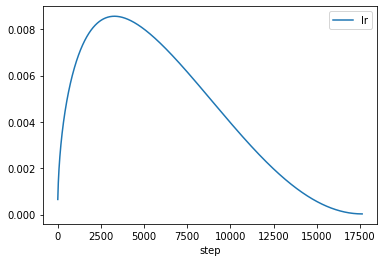

In [10]:
df_hist.plot(x="step", y="lr")

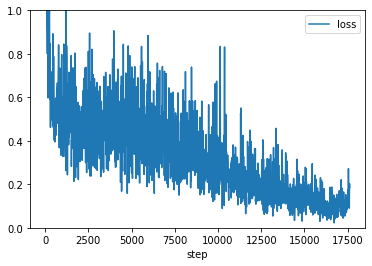

In [11]:
df_hist.plot(x="step", y="loss", ylim=(0,1))

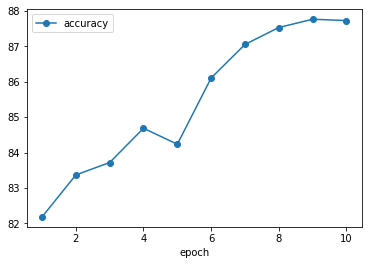

In [12]:
df_eval.plot(x="epoch", y="accuracy", marker="o")